# Import TAPAS Logfiles and create plots

In [117]:
def calcA(log):
    """ Extract Bitrate, Throughput, Roundtriptime and Quality per Segment
    INPUT: TAPAS Logfile as Dataframe
    OUTPUT: Dataframe [Bn*Cn, Dn, RTT, Quality]
    """ 
    df = log[1]
    name = log[0]
    downloaded_bytes = []
    bitrate = []
    duration = 4 
    rtt = []
    an = []
    qual = []
    for i, val in enumerate(df["downloaded_bytes"]):
        if i>1 and df.at[(i-1),"downloaded_bytes"] != val:
            zeit = (df.at[i,"ts_stop_req"] - df.at[(i-1),"ts_start_req"])/1000 #ms->s
            download_bytes = df.at[i,"downloaded_bytes"]-df.at[(i-1),"downloaded_bytes"] #bytes
            downloaded_bytes.append(download_bytes/1024) #in KB/s
            rtt.append(zeit);
            #Qualitätsstufe in KB/s
            quality = df.at[i,"level,visible=1,subplot=3"]
            qual.append(quality)
            bitrate.append((df.at[(i-1),"q"+str(quality)+",visible=0"]*duration)/1024)
            an.append(zeit+bitrate[-1]/downloaded_bytes[-1])
            

    d = {'d_n': downloaded_bytes, 'b_n*c_n': bitrate, 'a_n': an, 'rtt': rtt, 'quality': qual}
    df_ = pandas.DataFrame(data=d)
    return df_

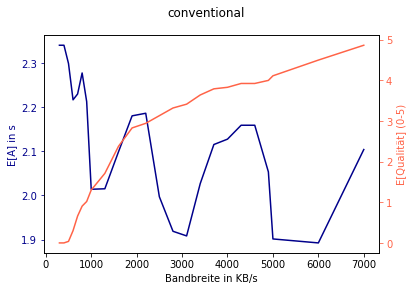

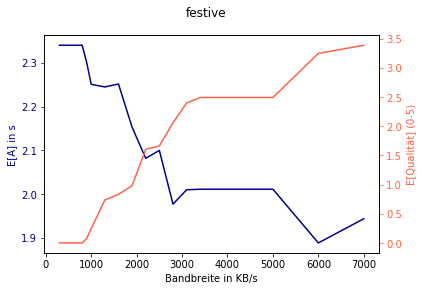

In [120]:
import os 
import pprint
import csv
import sys
import pandas
from datetime import datetime as dt
import matplotlib.pyplot as plt
from operator import itemgetter
import numpy as np
from scipy.stats import variation


def list_files(dir):
    """List all logfiles in a dir"""
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            if(name.endswith('.log')):
                r.append(os.path.join(name))
    return r

#conventional, festive
def getHeuristic(heuristic):
    """Import all logs for a specific heuristic"""
    logs = list_files("../has-evalvm/logfiles") #path to folder with logfiles
    #e.g. player_4000_1_parkour_conventional_2018-01-23-15.36.23_4362_139926172208336.log
    values = []
    for name in logs:
        if heuristic in name:
            df = pandas.read_csv("../has-evalvm/logfiles/"+name, sep=' ')
            df["#ts"] = df["#ts"].astype(int)
            df["ts_start_req"] = df["ts_start_req"].astype("int64")
            df["ts_stop_req"] = df["ts_stop_req"].astype("int64")
            for i, val in enumerate(df["#ts"]):
                df.at[i, "#ts"] = dt.fromtimestamp(val)
            values.append((int(name.split("_")[1]), df))
            values.sort(key=lambda tup: tup[0])
    return values

def meanValues(df_):
    """ Get average inter-arrival time and quality"""
    cn_bn = df_["b_n*c_n"]
    dn = df_["d_n"]
    rtt = df_["rtt"]
    qual = df_["quality"]
    ewC= np.mean(cn_bn)
    ewD = np.mean(dn)
    cov = np.cov([cn_bn,dn])[0][0]
    ewA = ewC/ewD - cov/(ewD*ewD) + ewC/(ewD*ewD*ewD) * np.var(dn) #Appendix A
    return [ewA, np.mean(qual)]
    
def plotAn(heuristic):
    """Plot average inter-arrival time and quality for specific heuristic """
    heur = getHeuristic(heuristic)
    names = []
    means = []
    qualities = []
    for x in heur:
        names.append(str(x[0]))
        raw = meanValues(calcA(x))
        means.append(raw[0])
        qualities.append(raw[1])

    fig, ax = plt.subplots()
    fig.suptitle(heuristic)
    ax.plot(names,means, "darkblue")
    ax.set_xlabel('Bandbreite in KB/s')
    ax.set_ylabel("E[A] in s", color="darkblue")
    ax.tick_params('y', colors='darkblue')

    ax0 = ax.twinx()
    ax0.plot(names,qualities, "tomato")
    ax0.set_ylabel('E[Qualität] (0-5)', color='tomato')
    ax0.tick_params('y', colors='tomato')

    plt.show()

plotAn("conventional")
plotAn("festive")

In [6]:
logs = list_files("../has-evalvm/logfiles")
p = pprint.PrettyPrinter(indent=4)
#p.pprint(logs)